# Code adapted from
* https://dzlab.github.io/dltips/en/pytorch/torchtext-datasets/ to use custom dataset
* https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/3%20-%20Faster%20Sentiment%20Analysis.ipynb to use model

In [1]:
def generate_bigrams(x):
    n_grams = set(zip(*[x[i:] for i in range(2)]))
    for n_gram in n_grams:
        x.append(' '.join(n_gram))
    return x

In [2]:
import torch
from torchtext.legacy import data
from torchtext.legacy import datasets

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  preprocessing = generate_bigrams)

LABEL = data.LabelField(dtype = torch.float)

In [3]:
BATCH_SIZE = 128#64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train, val, test = data.TabularDataset.splits(
    path='./data', train='Train.csv',
    validation='Val.csv', test='Test.csv', format='csv',
    fields=[('text', TEXT),(None, None), ('label', LABEL)],
    skip_header = True)# ignore helpfulness column
    # columns are Text, helpfulness, and rating

train_iter, val_iter, test_iter = data.BucketIterator.splits(
    (train, val, test), batch_sizes=(BATCH_SIZE,BATCH_SIZE,BATCH_SIZE),
    sort_key=lambda x: len(x.text), device = device)

In [4]:
MAX_VOCAB_SIZE = 50_000

TEXT.build_vocab(train, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train)

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class FastText(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        self.fc = nn.Linear(embedding_dim, output_dim)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
                
        #embedded = [sent len, batch size, emb dim]
        
        embedded = embedded.permute(1, 0, 2)
        
        #embedded = [batch size, sent len, emb dim]
        
        pooled = F.avg_pool2d(embedded, (embedded.shape[1], 1)).squeeze(1) 
        
        #pooled = [batch size, embedding_dim]
                
        return self.fc(pooled)

In [6]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
OUTPUT_DIM = 1
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

#model = FastText(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM, PAD_IDX)

In [7]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc, rounded_preds

In [8]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    preds=[]
    labels=[]
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc, rounded_preds = binary_accuracy(predictions, batch.label)
        preds.extend(rounded_preds.detach().to('cpu').numpy())
        labels.extend(batch.label.detach().to('cpu').numpy())
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), preds, labels

In [9]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    preds=[]
    labels=[]
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            loss = criterion(predictions, batch.label)
            
            acc, rounded_preds = binary_accuracy(predictions, batch.label)
            preds.extend(rounded_preds.detach().to('cpu').numpy())
            labels.extend(batch.label.detach().to('cpu').numpy())
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), preds, labels

In [10]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [56]:
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
from tqdm.notebook import  tqdm

In [ ]:
import torch.optim as optim


def train_model(adam=0,lr=0.001,epochs=5):
    # use base adam if adam <=0.5 otherwise use adamW with weight decay
    model = FastText(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM, PAD_IDX)
    pretrained_embeddings = TEXT.vocab.vectors
    model.embedding.weight.data.copy_(pretrained_embeddings)
    UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
    model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
    model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
    
    optimizer = optim.Adam(model.parameters(),lr=lr) if adam<=0.5 else optim.AdamW(model.parameters(),lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    model = model.to(device)
    criterion = criterion.to(device)
    N_EPOCHS = round(epochs)
    #best_valid_loss = float('inf')
    start_time = time.time()
    for epoch in tqdm(range(N_EPOCHS)):

        

        train_loss, train_acc, t_preds, t_labels = train(model, train_iter, optimizer, criterion)
        valid_loss, valid_acc, v_preds, v_labels = evaluate(model, val_iter, criterion)
        f1 = f1_score(v_labels, v_preds, average="macro")
       
        #print('gt: {}'.format(np.unique(v_labels)))
        #print('preds: {}'.format(np.unique(v_preds)))
        
       # if valid_loss < best_valid_loss:
       #     best_valid_loss = valid_loss
       #     torch.save(model.state_dict(), 'sentiment.pt')
        
        #print(f'Epoch: {epoch+1:02}')# | Epoch Time: {epoch_mins}m {epoch_secs}s'
        #print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        #print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print('F1: {}'.format(f1))
    print('Precision: {}'.format(precision_score(v_labels, v_preds, average="macro")))
    print('Recall: {}'.format(recall_score(v_labels, v_preds, average="macro")))
    print(f'Total Train time for {N_EPOCHS} epochs: {epoch_mins}m {epoch_secs}s')
    print("------------------------------------------------------------")
    return f1
    
    

In [22]:
train_model(epochs=1)

F1: 0.7321615005274933
Precision: 0.7979085425996042
Recall: 0.6993520708456674
Total Train time for 1 epochs: 1m 41s
------------------------------------------------------------


0.7321615005274933

In [23]:
from bayes_opt import BayesianOptimization
# Bounded region of parameter space
pbounds = {'adam':(0,1),'lr': (0.00001, 0.05), 'epochs': (3, 12)}

optimizer = BayesianOptimization(
    f=train_model,
    pbounds=pbounds,
    random_state=SEED,
)
optimizer.maximize(
    init_points=5,
    n_iter=7,
)

|   iter    |  target   |   adam    |  epochs   |    lr     |
-------------------------------------------------------------
F1: 0.7910539301684277
Precision: 0.774177770979543
Recall: 0.8133883653864507
Total Train time for 9 epochs: 15m 35s
------------------------------------------------------------
|  1        |  0.7911   |  0.1915   |  8.599    |  0.02189  |
F1: 0.7921287963594777
Precision: 0.7779814290509286
Recall: 0.8098067280408396
Total Train time for 10 epochs: 17m 11s
------------------------------------------------------------
|  2        |  0.7921   |  0.7854   |  10.02    |  0.01364  |
F1: 0.7903696900962036
Precision: 0.7750797204622906
Recall: 0.809959569829691
Total Train time for 10 epochs: 17m 15s
------------------------------------------------------------
|  3        |  0.7904   |  0.2765   |  10.22    |  0.04791  |
F1: 0.7941959654498039
Precision: 0.7855128781634907
Recall: 0.8040351362680025
Total Train time for 6 epochs: 10m 10s
-------------------------------

In [34]:
bayes_values=[]
bayes_params=[]
for i, res in enumerate(optimizer.res):
    bayes_values.append(res['target'])
    bayes_params.append(f"Iteration {i}")
    print("Iteration {}: \n\t{}".format(i, res))

Iteration 0: 
	{'target': 0.7910539301684277, 'params': {'adam': 0.1915194503788923, 'epochs': 8.598978939358487, 'lr': 0.021892009672965652}}
Iteration 1: 
	{'target': 0.7921287963594777, 'params': {'adam': 0.7853585837137692, 'epochs': 10.019782273069232, 'lr': 0.013636904338079254}}
Iteration 2: 
	{'target': 0.7903696900962036, 'params': {'adam': 0.2764642551430967, 'epochs': 10.216849597815173, 'lr': 0.047907386290648425}}
Iteration 3: 
	{'target': 0.7941959654498039, 'params': {'adam': 0.8759326347420947, 'epochs': 6.2203554296208, 'lr': 0.0250547463249177}}
Iteration 4: 
	{'target': 0.7932058931911014, 'params': {'adam': 0.6834629351721363, 'epochs': 9.414318242846102, 'lr': 0.018518835231971842}}
Iteration 5: 
	{'target': 0.7856920037617496, 'params': {'adam': 0.8830584948954096, 'epochs': 6.044450951635342, 'lr': 0.025103841296604194}}
Iteration 6: 
	{'target': 0.7942047415202709, 'params': {'adam': 0.9167281615240777, 'epochs': 8.552157187446348, 'lr': 0.014613657887185764}}
I

best params: {'target': 0.7949380350388444, 'params': {'adam': 0.26825798565095393, 'epochs': 3.795299442287926, 'lr': 0.008888927807508653}}


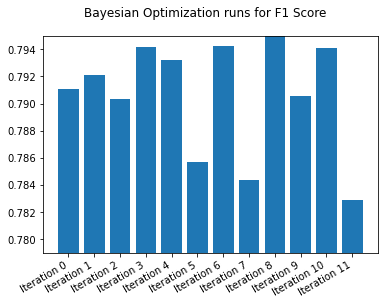

In [61]:
import matplotlib.pyplot as plt
import math
fig, ax = plt.subplots(1, 1)

plt.ylim([0.779, 0.795])
fig.suptitle('Bayesian Optimization runs for F1 Score')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.bar(bayes_params, bayes_values)
print('best params: {}'.format(optimizer.max))

In [59]:
def train_model_save(adam=0,lr=0.001,epochs=5):
    # use base adam if adam <=0.5 otherwise use adamW with weight decay
    model = FastText(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM, PAD_IDX)
    pretrained_embeddings = TEXT.vocab.vectors
    model.embedding.weight.data.copy_(pretrained_embeddings)
    UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
    model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
    model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
    optimizer = optim.Adam(model.parameters(),lr=lr) if adam<=0.5 else optim.AdamW(model.parameters(),lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    model = model.to(device)
    criterion = criterion.to(device)
    N_EPOCHS = round(epochs)
    start_time = time.time()

    best_valid_f1 = 0

    for epoch in tqdm(range(N_EPOCHS)):

        start_time = time.time()

        train_loss, train_acc, t_preds, t_labels = train(model, train_iter, optimizer, criterion)
        valid_loss, valid_acc, v_preds, v_labels = evaluate(model, val_iter, criterion)
        
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        f1 = f1_score(v_labels, v_preds, average="macro")
        print('F1: {}'.format(f1))
        print('Precision: {}'.format(precision_score(v_labels, v_preds, average="macro")))
        print('Recall: {}'.format(recall_score(v_labels, v_preds, average="macro")))
        if f1 > best_valid_f1:
            best_valid_f1 = f1
            torch.save(model.state_dict(), 'sentiment.pt')

        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    return model

In [60]:
model = train_model_save(adam= optimizer.max['params']['adam'], lr=optimizer.max['params']['lr'],
                 epochs=optimizer.max['params']['epochs'])

  0%|          | 0/4 [00:00<?, ?it/s]

F1: 0.7935477134470768
Precision: 0.7736405458699798
Recall: 0.8216740604569269
Epoch: 01 | Epoch Time: 1m 42s
	Train Loss: 0.319 | Train Acc: 87.05%
	 Val. Loss: 1.115 |  Val. Acc: 87.06%
F1: 0.7992317756188959
Precision: 0.7873363799156717
Recall: 0.8133940192155238
Epoch: 02 | Epoch Time: 1m 42s
	Train Loss: 0.274 | Train Acc: 89.06%
	 Val. Loss: 1.185 |  Val. Acc: 87.93%
F1: 0.7972328869179227
Precision: 0.7989828354643067
Recall: 0.795521169347366
Epoch: 03 | Epoch Time: 1m 43s
	Train Loss: 0.266 | Train Acc: 89.43%
	 Val. Loss: 1.140 |  Val. Acc: 88.41%
F1: 0.7903502491860268
Precision: 0.7698335870529356
Recall: 0.8200086609604819
Epoch: 04 | Epoch Time: 1m 45s
	Train Loss: 0.261 | Train Acc: 89.57%
	 Val. Loss: 1.253 |  Val. Acc: 86.79%


In [63]:
model.load_state_dict(torch.load('sentiment.pt'))
criterion = nn.BCEWithLogitsLoss()
test_loss, test_acc, t_preds, t_labels = evaluate(model, test_iter, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.197 | Test Acc: 87.98%


In [64]:
import spacy
nlp = spacy.load('en_core_web_sm')

def predict_sentiment(model, sentence):
    model.eval()
    tokenized = generate_bigrams([tok.text for tok in nlp.tokenizer(sentence)])
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    prediction = torch.sigmoid(model(tensor))
    return prediction.item()

In [76]:
predict_sentiment(model, "this is mediocre at best")

1.0

In [88]:
predict_sentiment(model, "I am so impressed with this item")

8.469452950521372e-06

# Problems
- Some words are not processed correctly: with f1 score tuning sentiments seem to be reversed?

In [91]:
import pandas as pd
df= pd.read_csv("Tokenized.csv")
df.head()

,Text,Helpfulness,Rating
0,"['daughter', 'wanted', 'book', 'price', 'Amazo...",1.000000,1
1,"['bought', 'zoku', 'quick', 'pop', 'daughterr'...",1.000000,1
2,"['shortage', 'pop', 'recipes', 'available', 'f...",2.059259,1
3,"['book', 'must', 'get', 'Zoku', 'also', 'highl...",1.855556,1
4,"['cookbook', 'great', 'really', 'enjoyed', 're...",1.000000,1


In [92]:
df["Prediction"]= df["Text"].map(lambda x:predict_sentiment(model, x))

In [93]:
df["Scaled_Prediction"]= df.apply(lambda row:(row['Prediction']*row['Helpfulness']), axis=1)

In [94]:
df.head()

,Text,Helpfulness,Rating,Prediction,Scaled_Prediction
0,"['daughter', 'wanted', 'book', 'price', 'Amazo...",1.000000,1,2.246930e-18,2.246930e-18
1,"['bought', 'zoku', 'quick', 'pop', 'daughterr'...",1.000000,1,2.309569e-19,2.309569e-19
2,"['shortage', 'pop', 'recipes', 'available', 'f...",2.059259,1,5.153782e-05,1.061297e-04
3,"['book', 'must', 'get', 'Zoku', 'also', 'highl...",1.855556,1,1.337574e-26,2.481943e-26
4,"['cookbook', 'great', 'really', 'enjoyed', 're...",1.000000,1,9.742831e-14,9.742831e-14


In [95]:
df.to_csv("results.csv",index=False)

In [96]:
df.Rating.value_counts()

1    455204
0     96478
Name: Rating, dtype: int64